# Chapter 5 RTM Model

This notebook is a translation of an example in Christophe Borgers' book, "An Introduction to Modeling Neuronal Dynamics"

requirements:

 bmtk

 NEURON 7.4+

### WB cell dynamics

Voltage and Gating Variables:

$C \frac{dV_{m}}{dt} = -\bar{g}_{K}n^4(V_{m} - V_{K}) - \bar{g}_{Na}m^3h(V_{m} - V_{Na}) - \bar{g}_{l}(V_{m} - V_{l}) + I$

$\frac{dn}{dt} = \alpha_{n}(V_{m})(1-n) - \beta_n(V_m)n$

$\frac{dm}{dt} = \alpha_{m}(V_{m})(1-m) - \beta_m(V_m)m$

$\frac{dh}{dt} = \alpha_{h}(V_{m})(1-h) - \beta_h(V_m)h$


RTM Cell Specific Properties

$\alpha_{n} = 0.032*(v+52)/(1-e^{-(v+52)/5})$

$\beta_{n} = 0.5*e^{-(v+57)/40}$

$\alpha_{m} = 0.32*(v+54)/(1-e^{-(v+54)/4})$

$\beta_{m} = 0.28*(v+27)/(e^{(v+27)/5}-1)$

$\alpha_{h} = 0.128*e^{-(v+50)/18}$

$\beta_{h} = 4./(1+e^{-(v+27)/5})$

## Plotting gating variables
Each equation was pulled from the na_rtm.mod and k_rtm.mod files. (Under components\\mechanisms)

These files describe sodium and potassium channel dynamics. The m and h gates are activation and inactivation gate variables respectively for the sodium channel. The n gate variable describes the potassium activation dynamics.

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    ! pip install -q h5py==2.9.0
    ! pip install -q bmtk==0.0.9
    ! pip install -q neuron==8.0.0
# as new version of neuron and bmtk come out we may need to install a specific version
import os
from os.path import normpath, sep, join

root = 'Borgers-Examples-in-BMTK' # name of github repo
folder = 'Chapter 5 - Three Simple Models of Neurons in Rodent Brains/RTM Model' # name of folder in Github just change this line 
pathlist = normpath(os.getcwd()).split(sep)
if pathlist[-1] != folder:
  rootidx = pathlist.index(root) if root in pathlist else -1
  if rootidx>0:
    os.chdir(join(sep,*pathlist[:rootidx]))
  !git clone https://github.com/GregGlickert/Borgers-Examples-in-BMTK
  os.chdir(join(root,folder))
print(os.getcwd())
%ls

     |████████████████████████████████| 2.8 MB 7.3 MB/s 
     |████████████████████████████████| 4.8 MB 7.6 MB/s 
     |████████████████████████████████| 12.6 MB 7.0 MB/s 
Cloning into 'Borgers-Examples-in-BMTK'...
remote: Enumerating objects: 912, done.
remote: Total 912 (delta 0), reused 0 (delta 0), pack-reused 912
Receiving objects: 100% (912/912), 31.14 MiB | 17.35 MiB/s, done.
Resolving deltas: 100% (490/490), done.
/content/Borgers-Examples-in-BMTK/Chapter 5 - Three Simple Models of Neurons in Rodent Brains/RTM Model
components/  RTM_Model.ipynb


In [2]:
%ls
%cd components/mechanisms/
!nrnivmodl
%cd ..
%cd ..
%ls

components/  RTM_Model.ipynb
/content/Borgers-Examples-in-BMTK/Chapter 5 - Three Simple Models of Neurons in Rodent Brains/RTM Model/components/mechanisms
/content/Borgers-Examples-in-BMTK/Chapter 5 - Three Simple Models of Neurons in Rodent Brains/RTM Model/components/mechanisms
Mod files: "./k_rtm.mod" "./k_wb.mod" "./leak.mod" "./na_rtm.mod" "./na_wb.mod" "./vecevent.mod"

Creating x86_64 directory for .o files.

COBJS=''
 -> NMODL ../k_rtm.mod
(cd ".."; MODLUNIT=/usr/local/lib/python3.7/dist-packages/neuron/.data/share/nrn/lib/nrnunits.lib /usr/local/lib/python3.7/dist-packages/neuron/.data/bin/nocmodl k_rtm.mod -o "/content/Borgers-Examples-in-BMTK/Chapter 5 - Three Simple Models of Neurons in Rodent Brains/RTM Model/components/mechanisms/x86_64")
 -> Compiling mod_func.c
x86_64-linux-gnu-gcc -O2   -I.   -I/usr/local/lib/python3.7/dist-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 -> NMODL ../leak.mod
 -> NMODL ../k_wb.mod
Translatin

In [3]:
import math

Voltage= []
minf = []
hinf = []
ninf = []
for i in range(150):
    Voltage.append(i-100)

for v in Voltage:
    ninf.append(1.0/(1.0+(math.exp((v+40.8)/(-11.03)))))
    minf.append(1.0/(1.0+(math.exp((v+41.03)/(-7.41)))))
    hinf.append(1.0/(1.0+(math.exp((v+45.32)/(4.04)))))

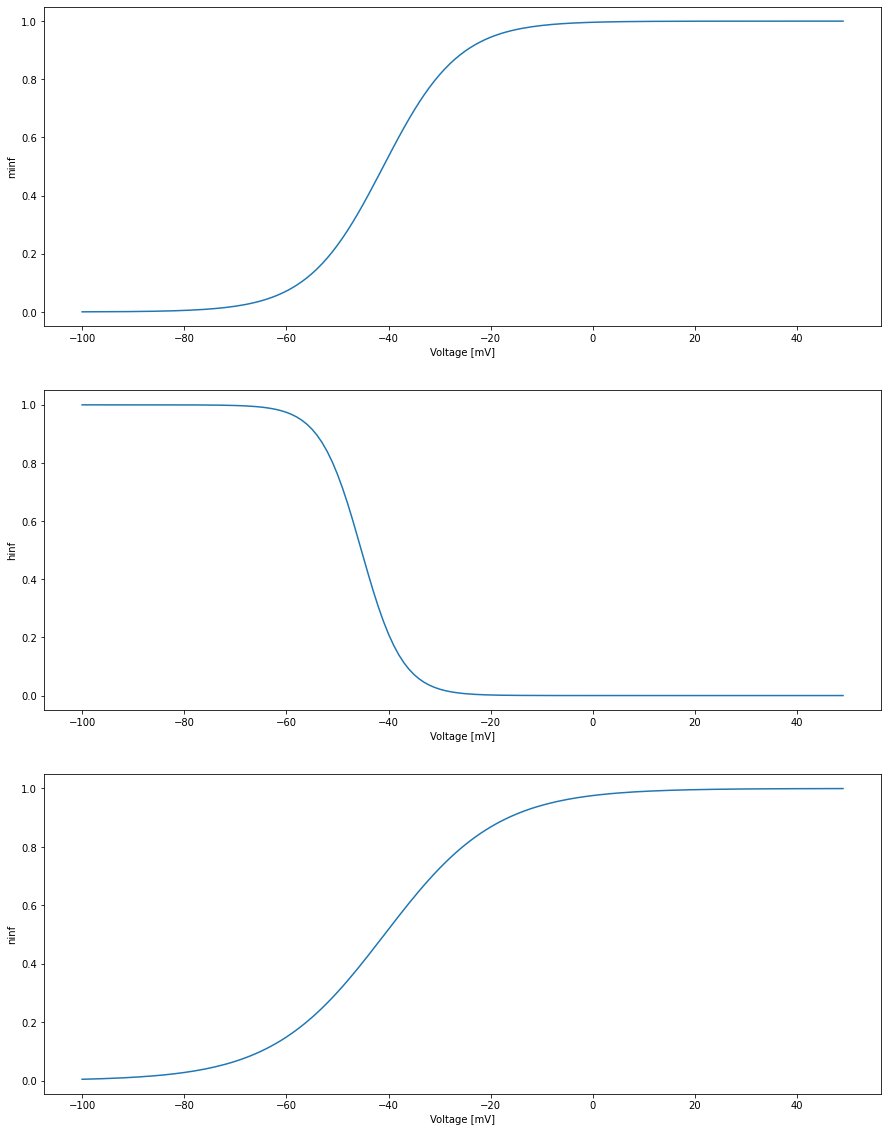

In [4]:
import matplotlib.pyplot as plt


fig1, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)

ax1.plot(Voltage, minf)
ax1.set_xlabel('Voltage [mV]')
ax1.set_ylabel('minf')

ax2.plot(Voltage, hinf)
ax2.set_xlabel('Voltage [mV]')
ax2.set_ylabel('hinf')

ax3.plot(Voltage, ninf)
ax3.set_xlabel('Voltage [mV]')
ax3.set_ylabel('ninf')


fig = plt.gcf()
fig.set_size_inches(15, 20)  # increase plot size

#If the plot does not appear run the cell again

# RTM Cell Simulation
##### We are now going to build a RTM neuron and place a current clamp on it using a python toolkit: bmtk.
    
### Building the Cell

We are now going to build a RTM neuron and place a current clamp on it using a python toolkit: bmtk.
    
### Building the Cell

In [5]:
import numpy as np
import logging

from bmtk.builder.networks import NetworkBuilder

n_E =1    # We are creating only 1 RTM cell

net = NetworkBuilder('network')
net.add_nodes(N=n_E, pop_name='Exc',     # N = number of excitatory cells
        model_type='biophysical',
        model_template='hoc:RTMExcCell', # RTMExcCell hoc definition
        morphology='blank.swc')

### Saving the Cell

In [6]:
net.build()
net.save_nodes(output_dir='network')

### Apply Current Clamp

In [7]:
current_amplitude = 2.3

import h5py
import os

try:
  os.isdir('input')
except:
  os.makedirs('input')

i_ext=[]
for i in range(100):
    i_ext.append(current_amplitude)

dts = [1]
gids = 'all'

#hf.close() # Uncomment this line temporarily if you receive 'file already open error'

hf = h5py.File("input/amps.h5", 'w')

hf.create_dataset("amplitudes", data=[i_ext])
hf.create_dataset("gids", data=gids)
hf.create_dataset("dts", data=dts)

hf.close()

### Build the Simulation Environment
This takes our saved features that we just made and creates simulation_config.json and circuit_config.json files. 

From these we can run our simulation (these files are already created so you don't need to run it).

In [8]:
from bmtk.utils.sim_setup import build_env_bionet

build_env_bionet(base_dir='.',
                 network_dir='network',
                 tstop=100.0, dt=0.1,
                 report_vars=['v'],           # Record membrane potential and calcium (default soma)
                 file_current_clamp={              # Creates a step current from 500.ms to 1500.0 ms
                      "input_type": "file_current_clamp",
                      "module": "FileIClamp",
                      "input_file":"input/amps.h5",
                      "node_set":"network"
                 },
                 v_init=-66.5,
                 include_examples=False,    # Copies components files
                 compile_mechanisms=False,   # Will try to compile NEURON mechanisms
                 config_file = 'config.json'
                )



# If this throws an error ignore and move on. This is because there is already a configuration file. If the next cell fails,
# then there is a real problem

### Run the Simulation

In [9]:
from bmtk.simulator import bionet


conf = bionet.Config.from_json('config.json')
conf.build_env()
net = bionet.BioNetwork.from_config(conf)
sim = bionet.BioSimulator.from_config(conf, network=net)
sim.run()

2022-10-04 03:01:24,421 [INFO] Created log file


INFO:NEURONIOUtils:Created log file


2022-10-04 03:01:24,490 [INFO] Building cells.


INFO:NEURONIOUtils:Building cells.


2022-10-04 03:01:24,500 [INFO] Building recurrent connections


INFO:NEURONIOUtils:Building recurrent connections


2022-10-04 03:01:24,513 [INFO] Running simulation for 100.000 ms with the time step 0.100 ms


/usr/local/lib/python3.7/dist-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
INFO:NEURONIOUtils:Running simulation for 100.000 ms with the time step 0.100 ms


2022-10-04 03:01:24,516 [INFO] Starting timestep: 0 at t_sim: 0.000 ms


INFO:NEURONIOUtils:Starting timestep: 0 at t_sim: 0.000 ms


2022-10-04 03:01:24,520 [INFO] Block save every 1000 steps


INFO:NEURONIOUtils:Block save every 1000 steps


2022-10-04 03:01:24,552 [INFO]     step:1000 t_sim:100.00 ms


INFO:NEURONIOUtils:    step:1000 t_sim:100.00 ms


2022-10-04 03:01:24,564 [INFO] Simulation completed in 0.05154 seconds 


INFO:NEURONIOUtils:Simulation completed in 0.05154 seconds 


### Display Results

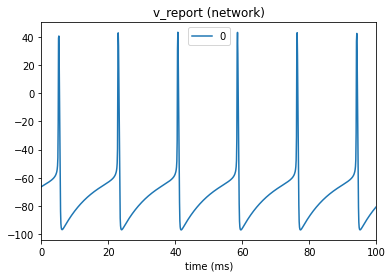

In [10]:
from bmtk.analyzer.compartment import plot_traces


_ = plot_traces(config_file='config.json', node_ids=[0], report_name='v_report')

We get a plot of a single RTM neuron under a current clamp